<a href="https://colab.research.google.com/github/Jayaprakash1710/Computer-Vision-Ninjacart/blob/main/Ninjacart_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File link: https://drive.google.com/file/d/1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT/view?usp=sharing

In [1]:
!gdown 1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT

Downloading...
From (original): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT
From (redirected): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT&confirm=t&uuid=091dbb18-176e-42f5-a8a4-f827a2d552d4
To: /content/ninjacart_data.zip
100% 275M/275M [00:07<00:00, 38.9MB/s]


In [2]:
!unzip /content/ninjacart_data.zip

Archive:  /content/ninjacart_data.zip
   creating: ninjacart_data/test/
   creating: ninjacart_data/test/indian market/
  inflating: ninjacart_data/test/indian market/bhl.jpeg  
  inflating: ninjacart_data/test/indian market/bhv.jpeg  
  inflating: ninjacart_data/test/indian market/bn.jpeg  
  inflating: ninjacart_data/test/indian market/hjx.jpeg  
  inflating: ninjacart_data/test/indian market/igis.jpeg  
  inflating: ninjacart_data/test/indian market/in.jpeg  
  inflating: ninjacart_data/test/indian market/india-4898453__340.jpg  
  inflating: ninjacart_data/test/indian market/indianmarket10.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket12.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket13.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket14.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket15.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket18.jpeg  
  inflating: ninjacart_data/test/indian market/

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import shutil
import random
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score

%matplotlib inline

In [4]:
def visualize_image_counts(dataset_type='train'):
    base_path = '/content/ninjacart_data'
    folder_path = os.path.join(base_path, dataset_type)
    class_counts = {}

    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            count = len(os.listdir(class_dir))
            class_counts[class_name] = count

    total_images = sum(class_counts.values())

    # Plotting
    plt.figure(figsize=(8, 6))
    bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title(f"Image Count per Class in {dataset_type.capitalize()} Set")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height),
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print class-wise and total count below the plot
    print("\nClass-wise counts:")
    for cls, count in class_counts.items():
        print(f"{cls} - {count}")
    print(f"Total {dataset_type} images - {total_images}")

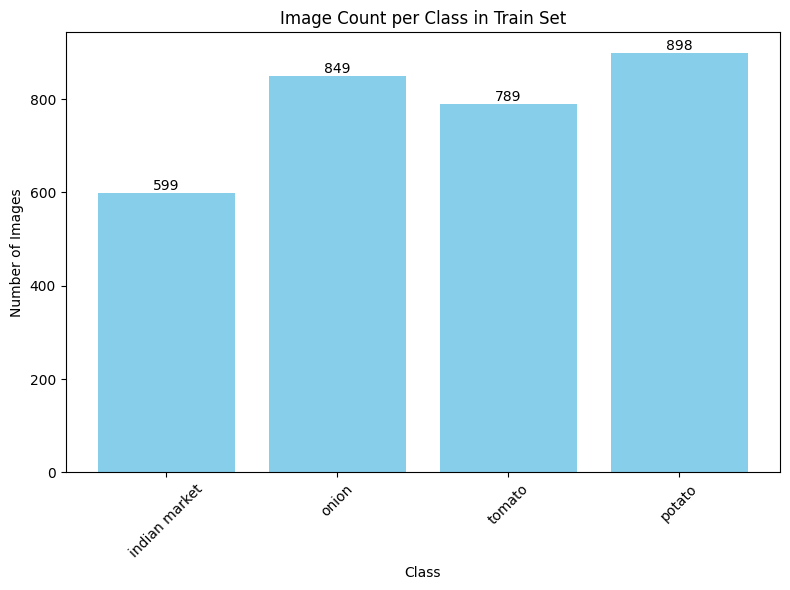


Class-wise counts:
indian market - 599
onion - 849
tomato - 789
potato - 898
Total train images - 3135


In [5]:
visualize_image_counts('train')

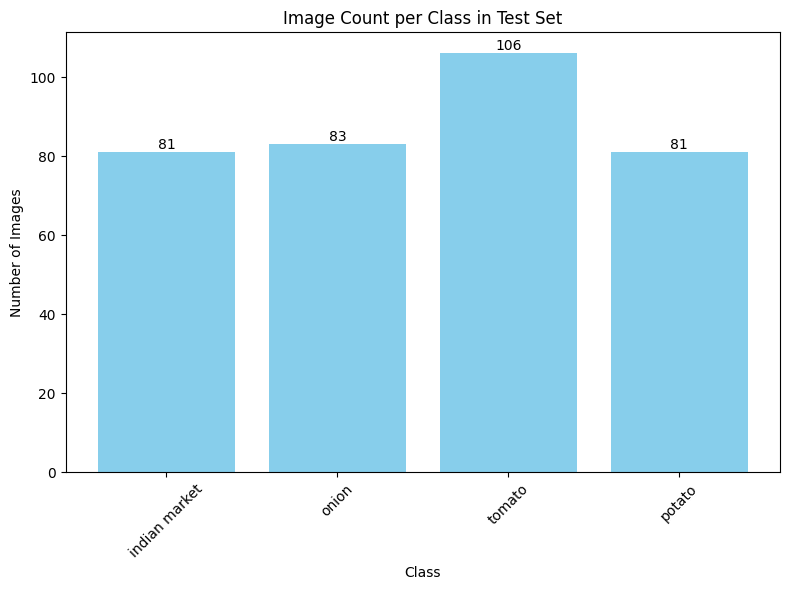


Class-wise counts:
indian market - 81
onion - 83
tomato - 106
potato - 81
Total test images - 351


In [6]:
visualize_image_counts("test")

In [7]:
def create_validation_split(train_dir='/content/ninjacart_data/train', val_dir='/content/ninjacart_data/val', val_split=0.15):
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(train_dir):
        class_train_path = os.path.join(train_dir, class_name)
        class_val_path = os.path.join(val_dir, class_name)

        if not os.path.isdir(class_train_path):
            continue

        os.makedirs(class_val_path, exist_ok=True)

        images = os.listdir(class_train_path)
        random.shuffle(images)

        val_count = int(len(images) * val_split)
        val_images = images[:val_count]

        for img in val_images:
            src_path = os.path.join(class_train_path, img)
            dst_path = os.path.join(class_val_path, img)
            shutil.move(src_path, dst_path)

    print("Validation split created.")

In [8]:
create_validation_split()

Validation split created.


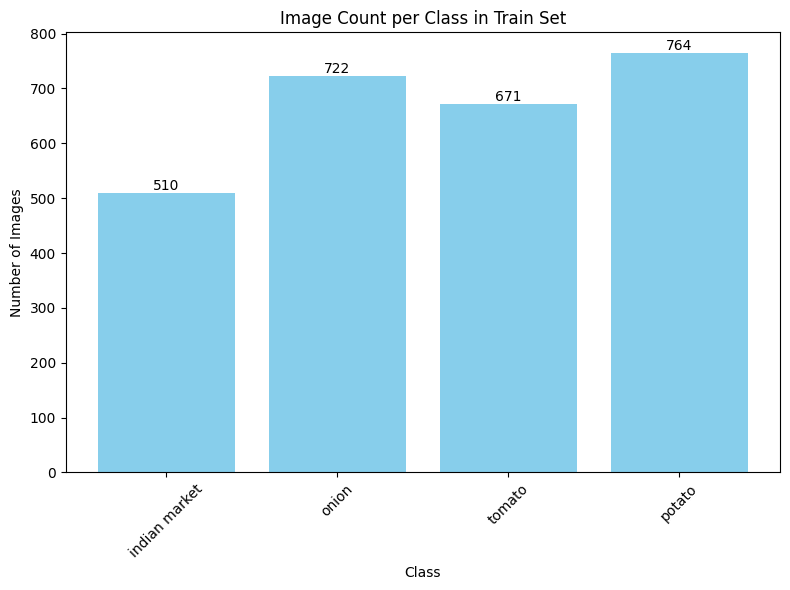


Class-wise counts:
indian market - 510
onion - 722
tomato - 671
potato - 764
Total train images - 2667


In [9]:
visualize_image_counts("train")

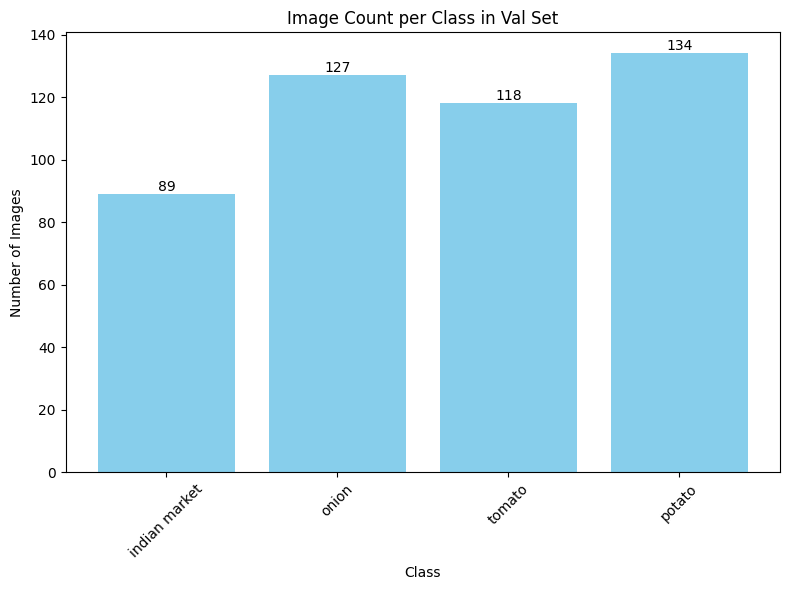


Class-wise counts:
indian market - 89
onion - 127
tomato - 118
potato - 134
Total val images - 468


In [10]:
visualize_image_counts("val")

In [11]:
def show_sample_images(train_dir='/content/ninjacart_data/train', samples_per_class=5):
    class_names = sorted(os.listdir(train_dir))
    plt.figure(figsize=(samples_per_class * 3, len(class_names) * 3))

    img_index = 1
    for class_name in class_names:
        class_path = os.path.join(train_dir, class_name)
        images = os.listdir(class_path)
        random.shuffle(images)
        images = images[:samples_per_class]

        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, _ = img.shape

            plt.subplot(len(class_names), samples_per_class, img_index)
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title(f"{class_name}\n{w}x{h}")
            img_index += 1

    plt.tight_layout()
    plt.show()

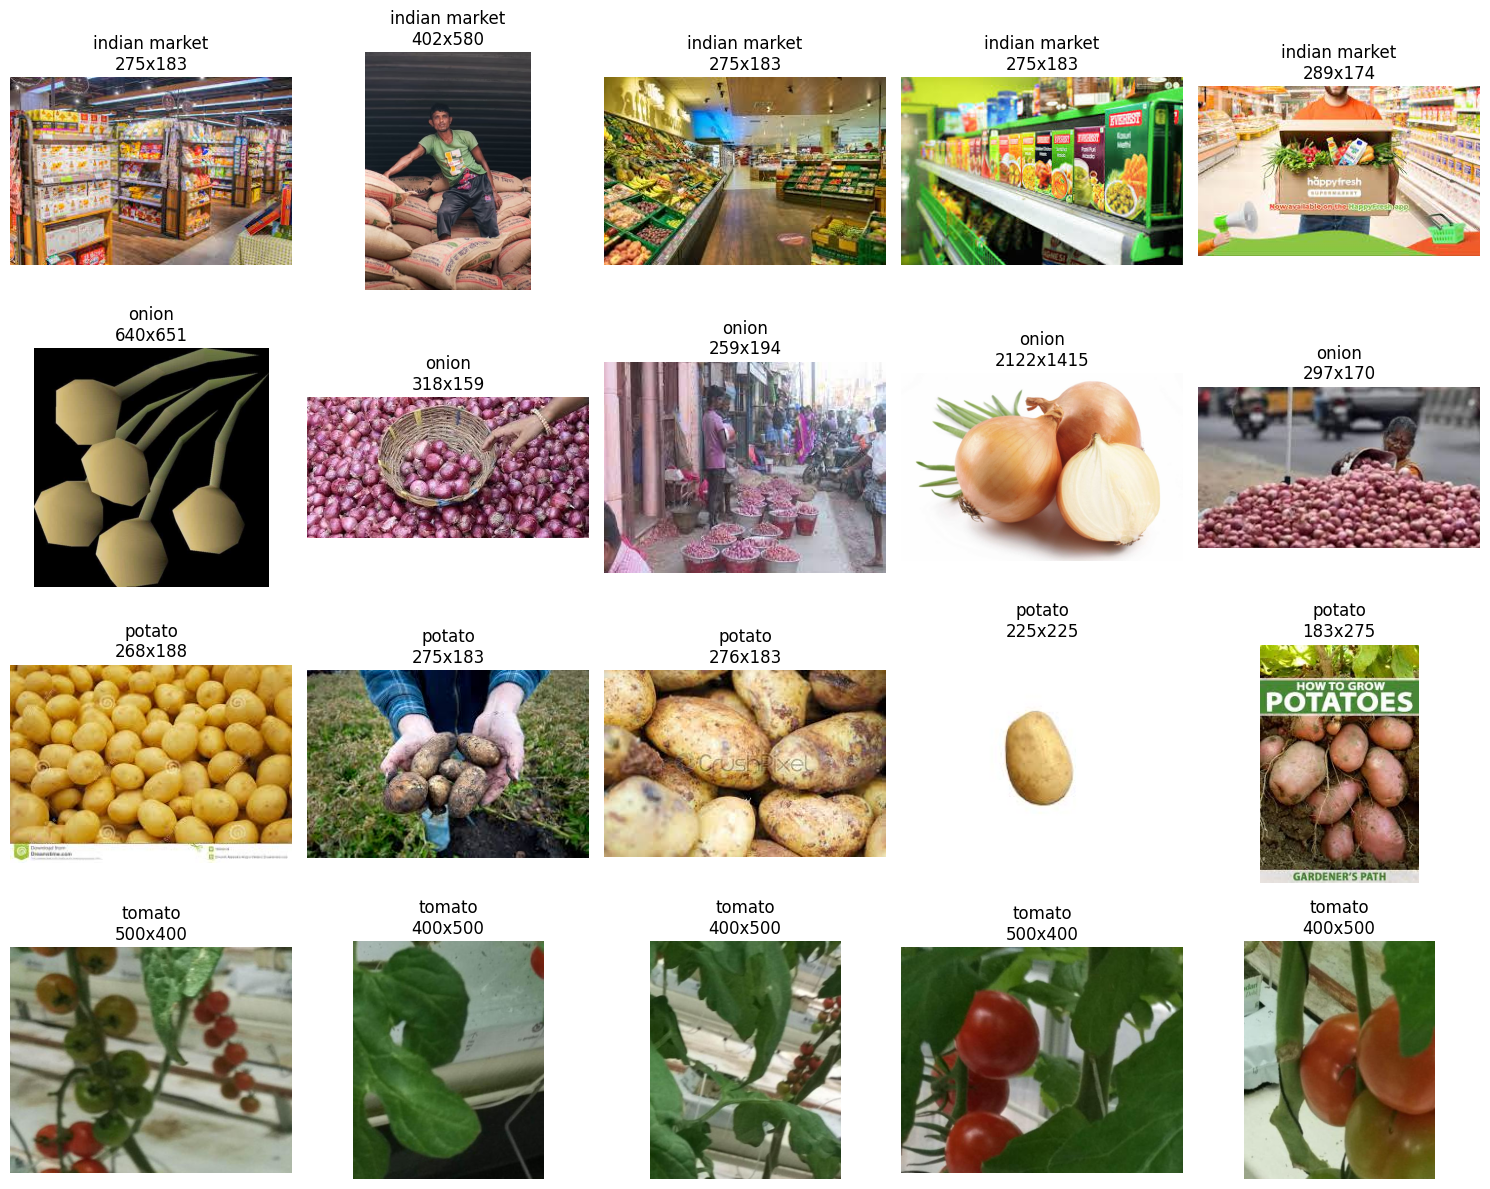

In [12]:
show_sample_images()

Loading the data into variables:

In [13]:
def load_data(base_dir="/content/ninjacart_data"):
    # checking if the data folders are present
    assert os.path.exists(f"{base_dir}/train") and os.path.exists(f"{base_dir}/val") and os.path.exists(f"{base_dir}/test")

    print('\nLoading Data...')
    train_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/train", shuffle=True, label_mode='categorical'
    )
    val_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/val", shuffle=False, label_mode='categorical'
    )
    test_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/test", shuffle=False, label_mode='categorical'
    )
    return train_data, val_data, test_data, train_data.class_names

In [14]:
train_data, val_data, test_data, class_names = load_data()


Loading Data...
Found 2667 files belonging to 4 classes.
Found 468 files belonging to 4 classes.
Found 351 files belonging to 4 classes.


Resizing and Rescaling images:

In [15]:
def preprocess(train_data, val_data, test_data, target_height=224, target_width=224):

    # Data Processing Stage with resizing and rescaling operations
    data_preprocess = keras.Sequential(
        name="data_preprocess",
        layers=[
            layers.Resizing(target_height, target_width),
            layers.Rescaling(1.0/255),
        ]
    )

    # Perform Data Processing on the train, val, test dataset
    train_ds = train_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = preprocess(train_data, val_data, test_data)

#Base Line model

In [17]:
def baseline(height=224, width=224):
    num_classes = 4
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn",
        layers=[
            layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(units=hidden_size, activation='relu'),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [18]:
model = baseline()
model.summary()

Model: "model_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 802816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │   205,521,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,523,972 (784.01 MB)

 Trainable params: 205,523,972 (784.01 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
def compile_train_v1(model, train_ds, val_ds, ckpt_path="/tmp/checkpoint.weights.h5"):
    epochs = 10
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    ])
    return model_fit

In [20]:
model_fit = compile_train_v1(model, train_ds, val_ds)

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 444ms/step - accuracy: 0.4970 - loss: 22.0198 - val_accuracy: 0.7500 - val_loss: 0.6845
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 70s 837ms/step - accuracy: 0.8606 - loss: 0.4103 - val_accuracy: 0.8312 - val_loss: 0.4722
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.9442 - loss: 0.1779 - val_accuracy: 0.8205 - val_loss: 0.4755
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.9759 - loss: 0.0812 - val_accuracy: 0.8077 - val_loss: 0.5336
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.9911 - loss: 0.0492 - val_accuracy: 0.8184 - val_loss: 0.5568
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.9913 - loss: 0.0351 - val_accuracy: 0.8269 - val_loss: 0.6213
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.9934 - loss: 0.0208 - val_accuracy: 0.8226 - val_loss: 0.6706
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 69s 830ms/step - accuracy: 0.9960 - loss: 0.0139 - val_accu

In [21]:
def annot_max(x,y, xytext=(0.94,0.96), ax=None, only_y=True):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    if only_y:
        text = "{:.2f}%".format(ymax)
    else:
        text= "x={:.2f}, y={:.2f}%".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=xytext, **kw)

def plot_accuracy(model_fit):
    #accuracy graph
    x = range(0,len(model_fit.history['accuracy']))
    y_train = [acc * 100 for acc in model_fit.history['accuracy']]
    y_val = [acc * 100 for acc in model_fit.history['val_accuracy']]

    plt.plot(x, y_train, label='Train', color='b')
    annot_max(x, y_train, xytext=(0.7,0.9))
    plt.plot(x, y_val, label='Val', color='r')
    annot_max(x, y_val, xytext=(0.8,0.7))
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

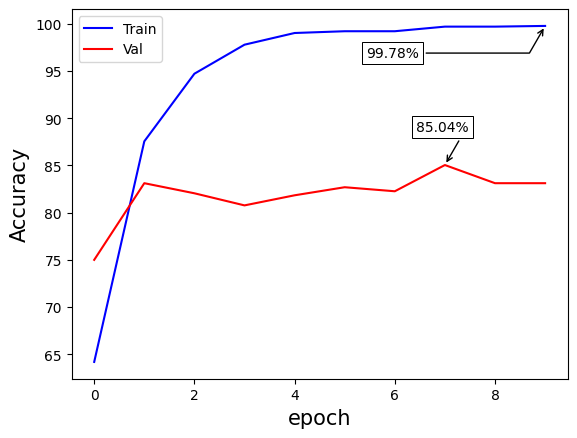

In [22]:
plot_accuracy(model_fit)

In [23]:
def print_accuracy_stats(model, ds, class_names):
    model.load_weights("/tmp/checkpoint.weights.h5")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)

    test_acc = accuracy_score(true_categories, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')

# Note: This doesn't work with shuffled datasets
def plot_confusion_matrix(model, ds, class_names):
    model.load_weights("/tmp/checkpoint.weights.h5")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    cm = confusion_matrix(true_categories,predicted_categories) # last batch
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu", fmt='g')
    plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step

Test Accuracy: 81.20%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


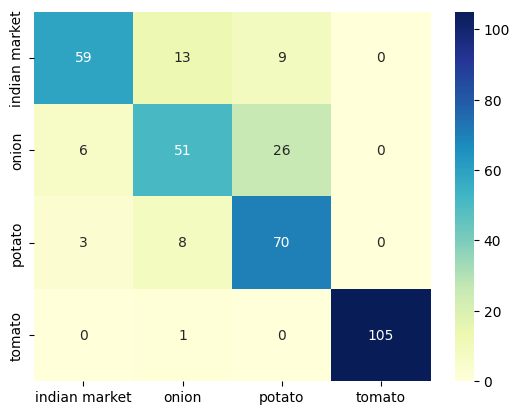

In [24]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Architecture-1

In [25]:
def arch_1(height=224, width=224):
    num_classes = 4
    hidden_size = 512

    model = keras.Sequential(
        name="model_cnn_1",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=512, kernel_size=3, padding="same", activation='relu'),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size, activation='relu'),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [26]:
model = arch_1()
model.summary()

Model: "model_cnn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,837,476 (7.01 MB)

 Trainable params: 1,837,476 (7.01 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
def compile_train_v1(model, train_ds, val_ds, epochs=10, ckpt_path="/tmp/checkpoint.weights.h5"):
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    ])
    return model_fit

In [28]:
model_fit = compile_train_v1(model, train_ds, val_ds)

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 200ms/step - accuracy: 0.4451 - loss: 1.1789 - val_accuracy: 0.6603 - val_loss: 0.7248
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.6790 - loss: 0.6876 - val_accuracy: 0.7500 - val_loss: 0.6053
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.7205 - loss: 0.6497 - val_accuracy: 0.7585 - val_loss: 0.5514
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.7827 - loss: 0.5308 - val_accuracy: 0.8226 - val_loss: 0.5395
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.8157 - loss: 0.4680 - val_accuracy: 0.8611 - val_loss: 0.3587
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.8366 - loss: 0.4106 - val_accuracy: 0.8440 - val_loss: 0.3802
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.8791 - loss: 0.3349 - val_accuracy: 0.8547 - val_loss: 0.3882
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.8718 - loss: 0.3317 - val_accu

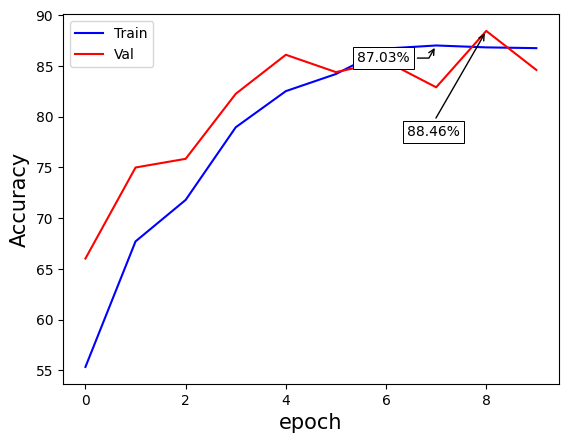

In [29]:
plot_accuracy(model_fit)

In [30]:
model_fit = compile_train_v1(model, train_ds, val_ds, epochs=30)

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.8727 - loss: 0.3554 - val_accuracy: 0.8996 - val_loss: 0.2797
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.8832 - loss: 0.2799 - val_accuracy: 0.8077 - val_loss: 0.4133
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.8893 - loss: 0.2874 - val_accuracy: 0.8269 - val_loss: 0.4021
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.8861 - loss: 0.2768 - val_accuracy: 0.8504 - val_loss: 0.3697
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.9015 - loss: 0.2507 - val_accuracy: 0.9017 - val_loss: 0.2664
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.9209 - loss: 0.2340 - val_accuracy: 0.8761 - val_loss: 0.3296
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.9029 - loss: 0.2386 - val_accuracy: 0.8974 - val_loss: 0.2535
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.8963 - loss: 0.2662 - val_accur

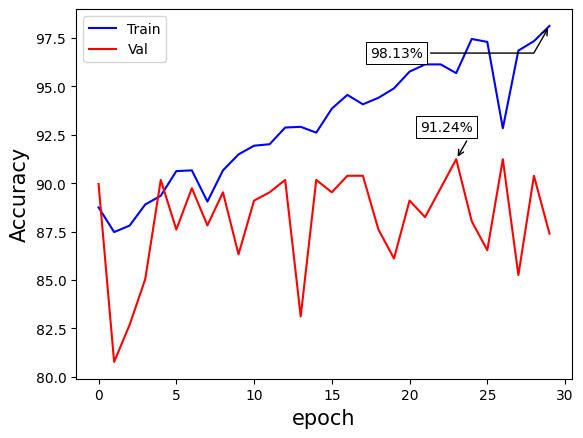

In [31]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step

Test Accuracy: 85.47%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


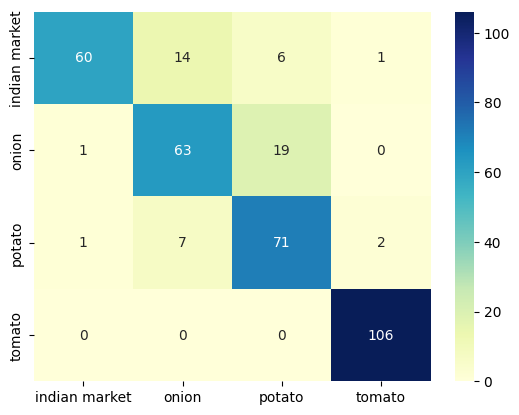

In [32]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Architecture-2

In [33]:
def arch_2(height=224, width=224):
    num_classes = 4
    hidden_size = 512

    model = keras.Sequential(
        name="model_cnn_2",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", input_shape=(height, width, 3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=512, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [34]:
model = arch_2()
model.summary()

Model: "model_cnn_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,843,556 (7.03 MB)

 Trainable params: 1,840,516 (7.02 MB)

 Non-trainable params: 3,040 (11.88 KB)

In [35]:
model_fit = compile_train_v1(model, train_ds, val_ds, epochs=30)

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 25s 180ms/step - accuracy: 0.7021 - loss: 0.9599 - val_accuracy: 0.2863 - val_loss: 4.0975
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.8025 - loss: 0.5994 - val_accuracy: 0.2906 - val_loss: 3.7397
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.8224 - loss: 0.4926 - val_accuracy: 0.2863 - val_loss: 3.1352
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.8435 - loss: 0.4306 - val_accuracy: 0.3034 - val_loss: 2.4421
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.8404 - loss: 0.4193 - val_accuracy: 0.4295 - val_loss: 2.1364
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.8577 - loss: 0.3674 - val_accuracy: 0.6410 - val_loss: 1.0384
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.8603 - loss: 0.3664 - val_accuracy: 0.7607 - val_loss: 0.5306
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.8728 - loss: 0.3527 - val_accur

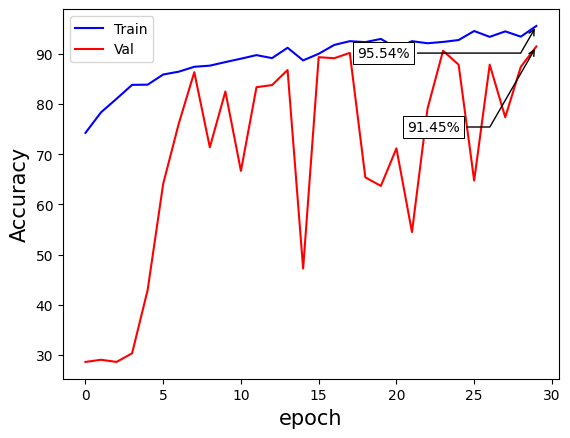

In [36]:
plot_accuracy(model_fit)

In [37]:
def compile_train_v2(model, train_ds, val_ds, epochs=10, ckpt_path="/tmp/checkpoint.weights.h5"):
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=10, min_lr=0.00001
        ),
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, min_delta=0.001, mode='min'
        )
    ]
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return model_fit

In [38]:
model = arch_2()
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 177ms/step - accuracy: 0.6719 - loss: 1.1250 - val_accuracy: 0.2949 - val_loss: 2.3644 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 30s 118ms/step - accuracy: 0.7636 - loss: 0.7077 - val_accuracy: 0.2906 - val_loss: 4.0108 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.8156 - loss: 0.5211 - val_accuracy: 0.4081 - val_loss: 3.0026 - learning_rate: 0.0010
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.8420 - loss: 0.4534 - val_accuracy: 0.4252 - val_loss: 2.5002 - learning_rate: 0.0010
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.8197 - loss: 0.4791 - val_accuracy: 0.7222 - val_loss: 0.6707 - learning_rate: 0.0010
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.8524 - loss: 0.3800 - val_accuracy: 0.5662 - val_loss: 1.9538 - learning_rate: 0.0010
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.8483 - lo

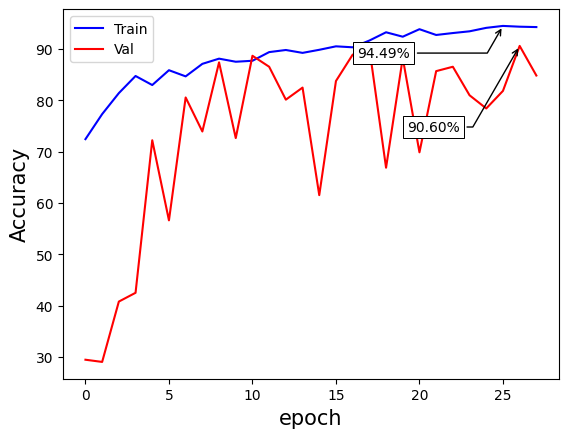

In [39]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step

Test Accuracy: 82.05%

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step


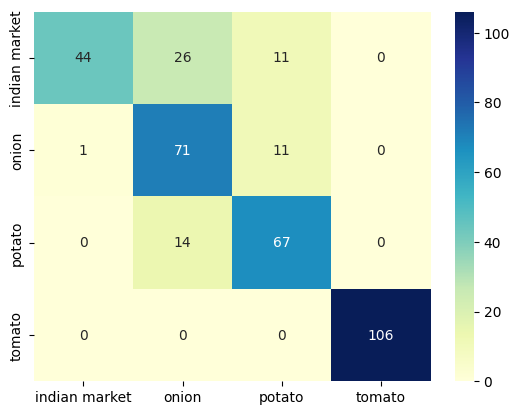

In [40]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Architecture-3

In [41]:
def arch_3(height=224, width=224):
    num_classes = 4
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn_3",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", input_shape=(height, width, 3),
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            # layers.MaxPooling2D(),
            # layers.Flatten(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size, kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [42]:
model = arch_3()
model.summary()

Model: "model_cnn_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 256)            │             

 Total params: 462,436 (1.76 MB)

 Trainable params: 460,932 (1.76 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [43]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 209ms/step - accuracy: 0.6744 - loss: 1.6090 - val_accuracy: 0.3120 - val_loss: 1.9154 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.8022 - loss: 1.1516 - val_accuracy: 0.3568 - val_loss: 1.9843 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.8025 - loss: 1.0953 - val_accuracy: 0.6239 - val_loss: 1.7993 - learning_rate: 0.0010
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.8369 - loss: 0.9819 - val_accuracy: 0.6197 - val_loss: 1.9560 - learning_rate: 0.0010
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.8364 - loss: 0.9300 - val_accuracy: 0.7051 - val_loss: 1.0936 - learning_rate: 0.0010
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.8409 - loss: 0.8865 - val_accuracy: 0.8034 - val_loss: 0.9100 - learning_rate: 0.0010
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.8605 - lo

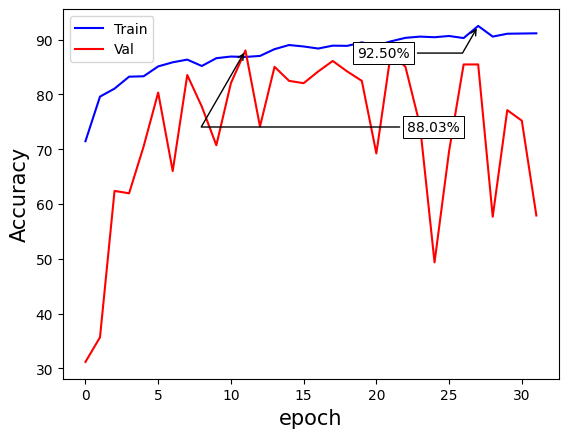

In [44]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step

Test Accuracy: 87.75%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


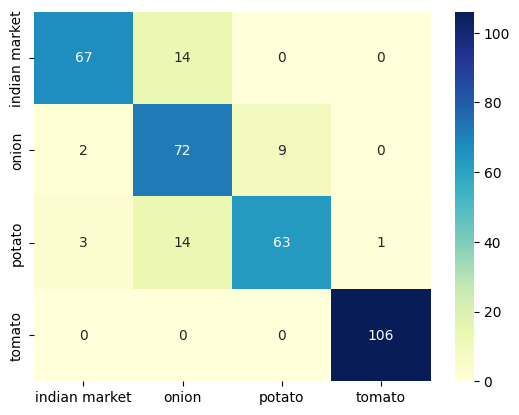

In [45]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Data Augmentation

In [46]:
def get_augmented_train_ds(path, img_size=(224, 224), batch_size=32):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.1),
        #tf.keras.layers.RandomBrightness(0.2),
        tf.keras.layers.RandomTranslation(0.05, 0.05),
        #tf.keras.layers.RandomCrop(img_size[0], img_size[1])
    ])

    raw_train_ds = tf.keras.utils.image_dataset_from_directory(
        path,
        image_size=img_size,
        batch_size=batch_size
    )

    class_names = raw_train_ds.class_names
    num_classes = len(class_names)

    # Apply augmentation + one-hot + performance tweaks
    augmented_train_ds = raw_train_ds.map(
        lambda x, y: (data_augmentation(x), tf.one_hot(y, depth=num_classes)),
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

    return augmented_train_ds, class_names

In [47]:
train_ds, class_names = get_augmented_train_ds('/content/ninjacart_data/train')

Found 2667 files belonging to 4 classes.


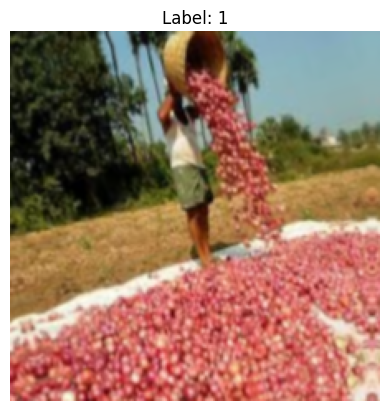

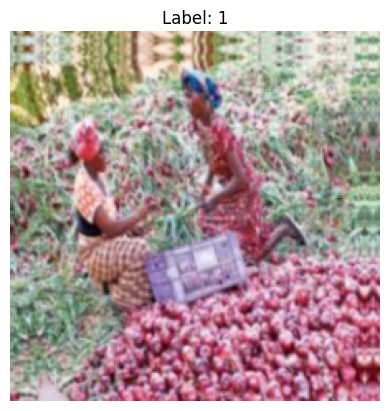

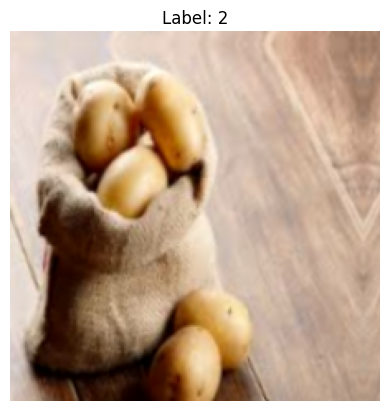

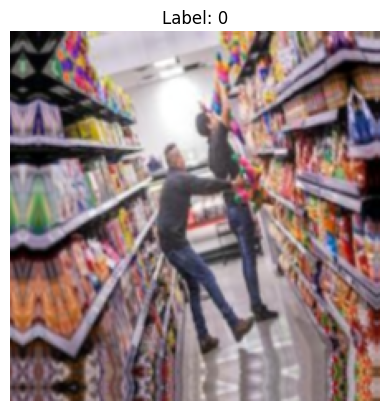

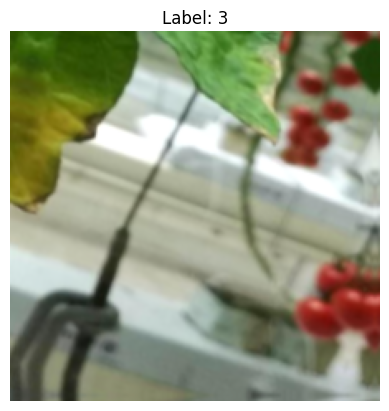

In [48]:
for images, labels in train_ds.take(1):
    for i in range(5):
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {tf.argmax(labels[i]).numpy()}")
        plt.axis('off')
        plt.show()

In [49]:
model = arch_3()
model.summary()

Model: "model_cnn_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 256)            │             

 Total params: 462,436 (1.76 MB)

 Trainable params: 460,932 (1.76 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [50]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 56s 546ms/step - accuracy: 0.6845 - loss: 1.5838 - val_accuracy: 0.2521 - val_loss: 2.7493 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 73s 479ms/step - accuracy: 0.7945 - loss: 1.1459 - val_accuracy: 0.4231 - val_loss: 2.1504 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 81s 491ms/step - accuracy: 0.8107 - loss: 1.0674 - val_accuracy: 0.4829 - val_loss: 2.1260 - learning_rate: 0.0010
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 490ms/step - accuracy: 0.8175 - loss: 0.9989 - val_accuracy: 0.5385 - val_loss: 1.9220 - learning_rate: 0.0010
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 81s 489ms/step - accuracy: 0.8318 - loss: 0.9642 - val_accuracy: 0.6838 - val_loss: 1.3273 - learning_rate: 0.0010
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 489ms/step - accuracy: 0.8438 - loss: 0.8979 - val_accuracy: 0.6944 - val_loss: 1.0253 - learning_rate: 0.0010
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 81s 482ms/step - accuracy: 0.8618 - l

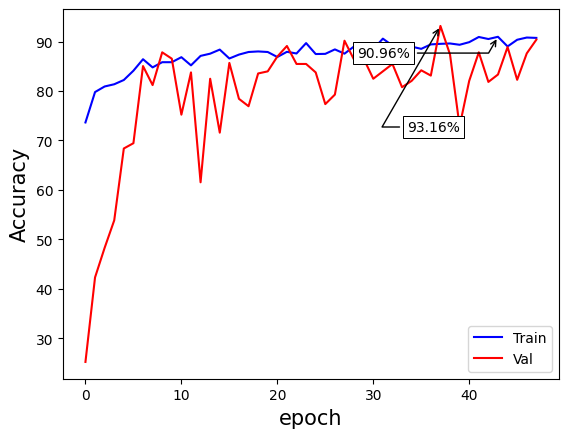

In [51]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step

Test Accuracy: 90.03%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


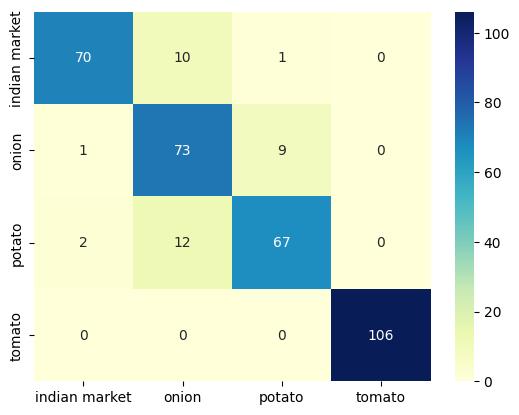

In [52]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Vgg-16

In [53]:
pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[224,224, 3])
pretrained_model.trainable=False
vgg16_model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [54]:
model=vgg16_model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │       100,356 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,815,044 (56.51 MB)

 Trainable params: 100,356 (392.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 73s 703ms/step - accuracy: 0.6770 - loss: 0.9490 - val_accuracy: 0.8953 - val_loss: 0.2431 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 58s 553ms/step - accuracy: 0.9104 - loss: 0.2297 - val_accuracy: 0.9338 - val_loss: 0.1818 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 523ms/step - accuracy: 0.9286 - loss: 0.1832 - val_accuracy: 0.9487 - val_loss: 0.1652 - learning_rate: 0.0010
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 85s 558ms/step - accuracy: 0.9408 - loss: 0.1639 - val_accuracy: 0.8996 - val_loss: 0.2174 - learning_rate: 0.0010
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 539ms/step - accuracy: 0.9350 - loss: 0.1634 - val_accuracy: 0.9359 - val_loss: 0.1904 - learning_rate: 0.0010
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 83s 558ms/step - accuracy: 0.9698 - loss: 0.0904 - val_accuracy: 0.9530 - val_loss: 0.1528 - learning_rate: 0.0010
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 532ms/step - accuracy: 0.9661 - l

In [ ]:
plot_accuracy(model_fit)

In [ ]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# ResNet 50

In [ ]:
pretrained_resnet = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
pretrained_resnet.trainable = False

resnet_model = tf.keras.Sequential([
    pretrained_resnet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:
model=resnet_model
model.summary()

In [ ]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

In [ ]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# MobileNet V2

In [ ]:
pretrained_mobilenet = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
pretrained_mobilenet.trainable = False

mobilenet_model = tf.keras.Sequential([
    pretrained_mobilenet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:
model=mobilenet_model
model.summary()

In [ ]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

In [ ]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)